In [69]:
import numpy as np 
import tensorflow as tf 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from bs4 import BeautifulSoup
import spacy
from tensorflow.keras import layers 
#import unidecode
#from word2number import w2n
#import pycontractions
#import contractions 


In [70]:
data = pd.read_csv(r'D:\project\resnet_basics\all_tickets.csv')
#data['ticket_type'].plot(kind = 'hist')

In [71]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB
None


# EXTRACTING REQUIRED VALUES

In [72]:
df = data.loc[:, ['title','body','category','sub_category1','sub_category1','urgency',]].copy()
df.head()

,title,body,category,sub_category1,sub_category1,urgency
0,NaN,hi since recruiter lead permission approve req...,4,2,2,3
1,connection with icon,icon dear please setup icon per icon engineers...,6,22,22,3
2,work experience user,work experience user hi work experience studen...,5,13,13,3
3,requesting for meeting,requesting meeting hi please help follow equip...,5,13,13,3
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,4,2,2,3


In [73]:
size = len(df)
size

48549

# ADDING EXTRA COLUMN

In [74]:
# 
df['department'] = np.random.randint(0,4,size=size)

In [75]:
df.isna().sum()

title            712
body               0
category           0
sub_category1      0
sub_category1      0
urgency            0
department         0
dtype: int64

In [76]:
# taking care of null values
df['title'] = df['title'].fillna("Value Missing")

In [77]:
def strip_html_tags(text): 
    """remove html tags""" 
    soup = BeautifulSoup(text, "html.parser") 
    stripped_text = soup.get_text(separator=" ") 
    return stripped_text 

def word2number(text):
    help_dict = { 
    'one': '1', 
    'two': '2', 
    'three': '3', 
    'four': '4', 
    'five': '5', 
    'six': '6', 
    'seven': '7', 
    'eight': '8', 
    'nine': '9', 
    'zero' : '0'
} 

    return  " ".join([help_dict[word] for word in text.split() if word in help_dict])

import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

# applying lemmatization
df['title'] = df['title'].apply(lemmatize_text)
df['body'] = df['body'].apply(lemmatize_text)



In [78]:
 from sklearn.feature_extraction.text import TfidfVectorizer 
 from sklearn.feature_extraction import text 
 mystopwords = text.ENGLISH_STOP_WORDS
 vectorizer_body = TfidfVectorizer(
     strip_accents='ascii',
     lowercase=True,
     stop_words='english',
 )
 
 body_ = vectorizer_body.fit_transform(df['body']) 


 vectorizer_title = TfidfVectorizer(
     strip_accents='ascii',
     lowercase=True,
     stop_words=mystopwords
 )

 title_ = vectorizer_title.fit_transform(df['title'])




In [86]:
# extracting tags
tags = df.loc[:,['category','sub_category1','sub_category1']]
tags

,category,sub_category1,sub_category1,sub_category1,sub_category1
0,4,2,2,2,2
1,6,22,22,22,22
2,5,13,13,13,13
3,5,13,13,13,13
4,4,2,2,2,2
...,...,...,...,...,...
48544,4,21,21,21,21
48545,4,9,9,9,9
48546,5,32,32,32,32
48547,4,21,21,21,21


In [87]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
tags_ = enc.fit_transform(tags)


In [88]:
priority_ = tf.keras.utils.to_categorical(df['urgency'])
department_ = tf.keras.utils.to_categorical(df['department'])

In [97]:
title_.shape[0]

(48549, 3587)

In [103]:
title = tf.keras.Input(shape=(title_.shape[1],), name = 'title')
text_body = tf.keras.Input(shape=(body_.shape[1],),name = 'body') 
tags = tf.keras.Input(shape=(tags_.shape[1],),name = 'tags')

features = layers.Concatenate()([title, text_body, tags])
batch_normalization = layers.BatchNormalization()(features)

features = layers.Dense(512, activation = 'relu')(batch_normalization)
batch_normalization = layers.BatchNormalization()(features)
dropout = layers.Dropout(0.3)(batch_normalization)

features = layers.Dense(512, activation = 'relu')(dropout)
batch_normalization = layers.BatchNormalization()(features)
dropout = layers.Dropout(0.3)(batch_normalization)

features = layers.Dense(128, activation = 'relu')(dropout)
batch_normalization = layers.BatchNormalization()(features)
dropout = layers.Dropout(0.3)(batch_normalization)
 
priority = layers.Dense(1, activation = 'sigmoid', name = 'priority')(dropout)

department = layers.Dense(4, activation = 'softmax', name = 'department')(dropout)

model = tf.keras.Model(inputs = [title,text_body, tags], outputs = [priority, department]) 

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 3587)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, 10317)]      0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 249)]        0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 14153)        0           title[0][0]                      
                                                                 body[0][0]                 

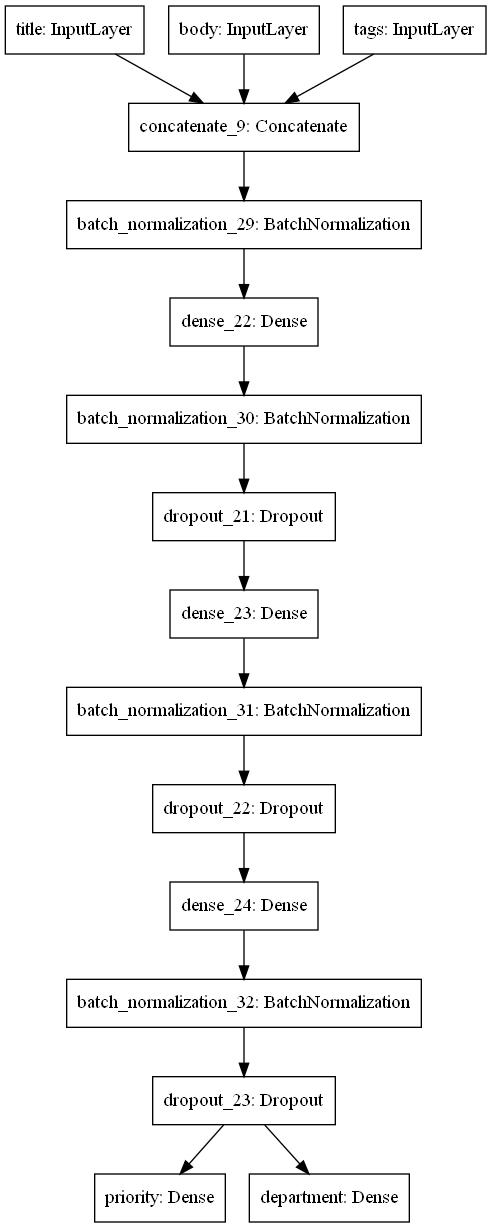

In [104]:
tf.keras.utils.plot_model(model, 'sample.jpg')

In [105]:
model.compile(optimizer='adam',
 loss=['mean_squared_error', 'categorical_crossentropy'],
 metrics=[['mean_absolute_error'], ['accuracy']]) 

In [106]:
model.fit({'title':title_.toarray(), 'body':body_.toarray(), 'tags': tags_.toarray()},
[priority_, department_],
epochs = 1
) 

1518/1518 [==============================] - 27s 16ms/step - loss: 1.8776 - priority_loss: 0.2264 - department_loss: 1.6512 - priority_mean_absolute_error: 0.4155 - department_accuracy: 0.2553


In [102]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 48549)]      0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, 48549)]      0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 48549)]      0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 145647)       0           title[0][0]                      
                                                                 body[0][0]                 